In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 

In [2]:
#parameters of processing
frequency = 30 #Hz
bag_file_name = '/data/dataset_ENVTACT_new2.bag'
time_window_size = 6
examples_per_edge = 1

bag_file = rosbag.Bag(bag_file_name)


In [3]:

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []

event_packet_size = []
event_packet_size_ts = []
contact_angle = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 17
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)

129
[[0, 0, 0], [0.016124739715682745, 0.006679085879971878, 0], [0.03224947943136549, 0.013358171759943756, 0], [0.048374219239436196, 0.02003725767818398, 0], [0.06929096493834651, 0.02870125742738173, 0], [0.08776855558857224, 0.03635492607468353, 0], [0.10624614623879798, 0.044008594721985324, 0], [0.12472373688902372, 0.05166226336928712, 0], [0.13858192987669302, 0.05740251485476346, 0], [0.01234134148078231, 0.012341341480782309, 0], [0.02468268296156462, 0.024682682961564617, 0], [0.03702402451305761, 0.037024024513057606, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.06717514421272203, 0.06717514421272201, 0], [0.08131727983645297, 0.08131727983645295, 0], [0.09545941546018392, 0.09545941546018391, 0], [0.10606601717798213, 0.10606601717798211, 0], [0.006679085879971879, 0.016124739715682745, 0], [0.013358171759943758, 0.03224947943136549, 0], [0.020037257678183984, 0.048374219239436196, 0], [0.028701257427381735, 0.06929096493834651, 0], [0.03635492607468353, 0.08776

In [4]:
def filter_events_by_time(events, time_of_contact, time_period = 0.3e9, threshold=20000):
    event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])
    event_in_time_idx = np.where((event_time > (time_of_contact - time_period)) * (event_time < time_of_contact))[0]
    print(len(event_in_time_idx))
    if len(event_in_time_idx) < threshold:
        return False, []
    else:
        print(event_in_time_idx)
        output_events = np.array(events)[event_in_time_idx,:]
        return True,output_events

In [5]:
from tqdm.auto import tqdm
for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_packet_size.append(len(msg.events))
        event_packet_size_ts.append(t.to_nsec())
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        contact_angle.append([msg.x, msg.y, msg.z])
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

0it [00:00, ?it/s]

In [6]:
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = np.arange(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

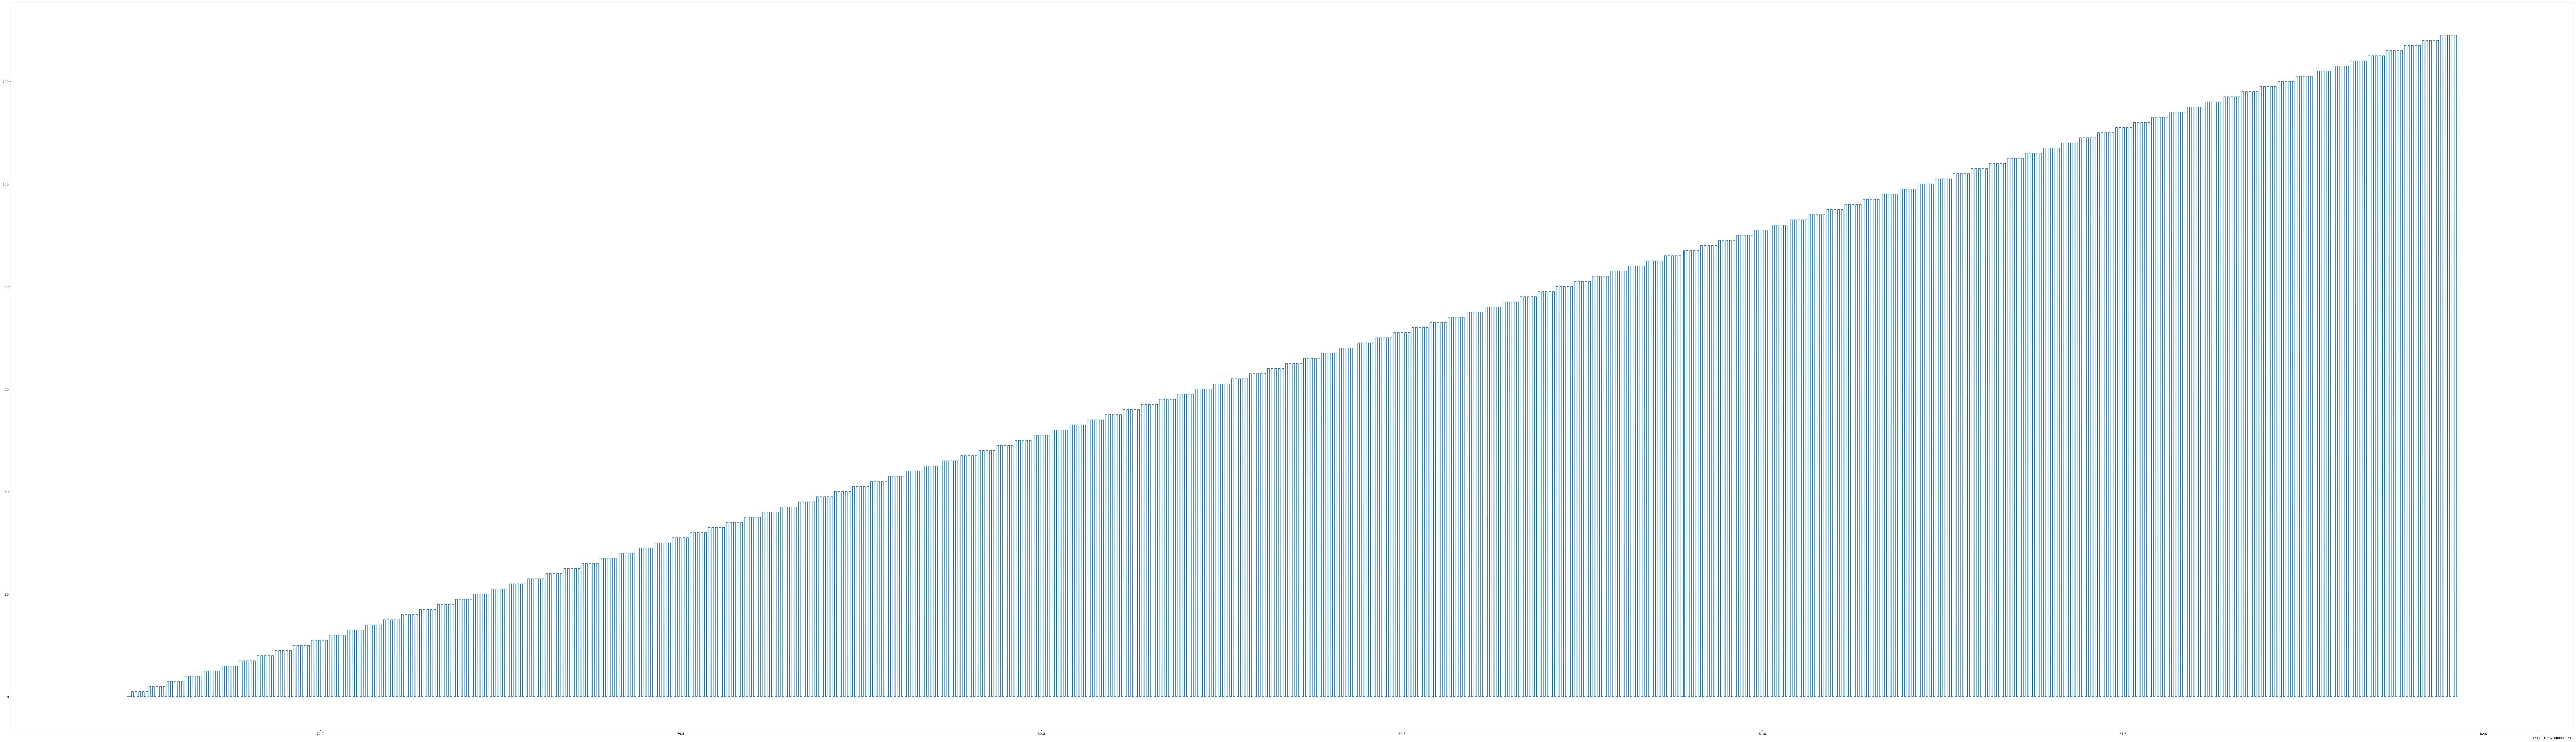

96927


In [7]:
plt.figure(figsize=(140,40))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [8]:
case_span = 2.66e9
find_ts_idx = lambda ts: np.searchsorted(contact_status_ts, ts)

def look_ahead_big(ts, idx_ts):
    fin_ts = ts + case_span
    fin_idx = find_ts_idx(fin_ts)
    print(fin_idx)
    if contact_status[fin_idx]:
        #look further
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ += 1
            if fin_idx_ - fin_idx > 25:
                print('warning more than 25 idx away from init_ts + case_span')
            if contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was before case ended by {fin_idx_ - fin_idx} indexes')
        fin_idx = fin_idx_ - 1
    else:
        #look backwards
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ -= 1
            if not contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was ahead case ended by {fin_idx - fin_idx} indexes')
        fin_idx = fin_idx_ + 1
        
    return contact_status_ts[fin_idx]


def find_case(ts):
    idx = find_ts_idx(ts)
    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    x, y, z = contact_angle[idx]
    for rot in list_of_rotations:
        diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    return best_rot_idx


i = 0 
cases_ts = []
cases_idx = []
cases = []
while i < len(contact_status):
    if contact_status[i]:
        init_ts = contact_status_ts[i]
        fin_ts = look_ahead_big(init_ts, i)
        fin_idx = find_ts_idx(fin_ts)
        case = find_case(np.mean([init_ts, fin_ts]))
        
        cases.append(case)
        cases_ts.append([init_ts, fin_ts])
        cases_idx.append([i, fin_idx])
        print(len(cases_ts), init_ts, fin_ts, (fin_ts - init_ts)*1e-9, i, fin_idx, case, '\n')
        i = fin_idx + 1
    else:
        i += 1

416
was ahead case ended by 0 indexes
1 1662378738268597072 1662378740888466220 2.6198691480000003 282 413 1 

663
was before case ended by 3 indexes
2 1662378743228413369 1662378745928494229 2.7000808600000004 530 665 1 

885
was ahead case ended by 0 indexes
3 1662378748308327497 1662378750836139442 2.5278119450000003 784 877 1 

1136
was ahead case ended by 0 indexes
4 1662378753308512546 1662378755868273794 2.559761248 1002 1130 1 

1383
was before case ended by 1 indexes
5 1662378758251080543 1662378760928476102 2.6773955590000003 1249 1383 1 

1585
was ahead case ended by 0 indexes
6 1662378762308217783 1662378764868165283 2.5599475000000003 1452 1580 2 

1834
was ahead case ended by 0 indexes
7 1662378767268328555 1662378769948127249 2.679798694 1700 1834 2 

2084
was before case ended by 1 indexes
8 1662378772268509465 1662378774948096529 2.679587064 1950 2084 2 

2334
was before case ended by 1 indexes
9 1662378777268214868 1662378779948277480 2.680062612 2200 2334 2 

2588
wa

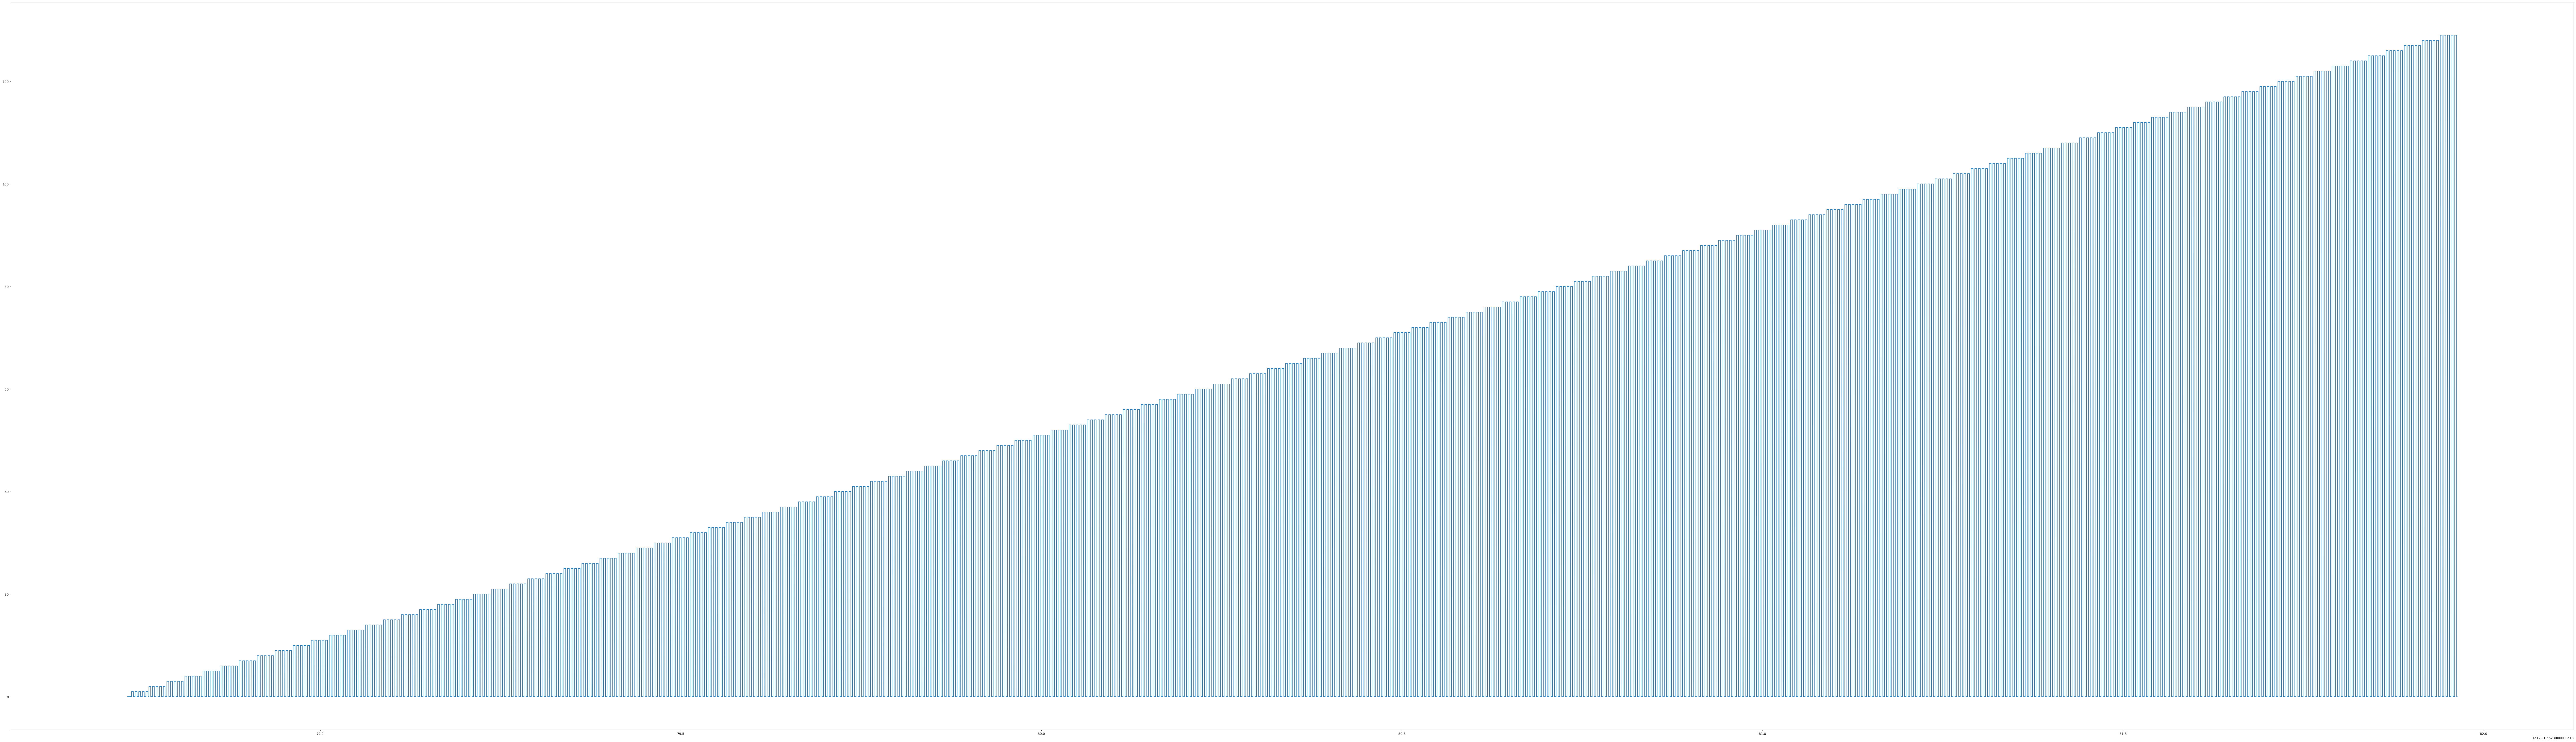

In [9]:
contact_case_alt = np.zeros(len(contact_status))
for i, case in enumerate(cases):
    contact_case_alt[cases_idx[i][0]:cases_idx[i][1] + 1] = case
    
plt.figure(figsize=(140, 40))
plt.plot(contact_status_ts, contact_case_alt)

In [10]:
f_case = interp1d(contact_status_ts, contact_case_alt, kind='previous')
contact_case_ts_alt_int = np.arange(min(contact_status_ts), max(contact_status_ts), int(1e9/frequency))

contact_case_alt_int = f_case(contact_case_ts_alt_int)

In [1]:
def find_interp_idx(ts):
    return np.where(ts - contact_case_ts_alt_int < 0)[0][0]

In [2]:
cases_int_idx = []

for i, case_ts in enumerate(cases_ts):
    case_int_idx = list(map(find_interp_idx, case_ts))
    cases_int_idx.append(case_int_idx)

NameError: name 'cases_ts' is not defined

In [13]:
cases_int_idx[:10], cases_idx[:10]

([[170, 248],
  [319, 400],
  [471, 547],
  [621, 698],
  [769, 850],
  [891, 968],
  [1040, 1120],
  [1190, 1270],
  [1340, 1420],
  [1492, 1568]],
 [[282, 413],
  [530, 665],
  [784, 877],
  [1002, 1130],
  [1249, 1383],
  [1452, 1580],
  [1700, 1834],
  [1950, 2084],
  [2200, 2334],
  [2454, 2580]])

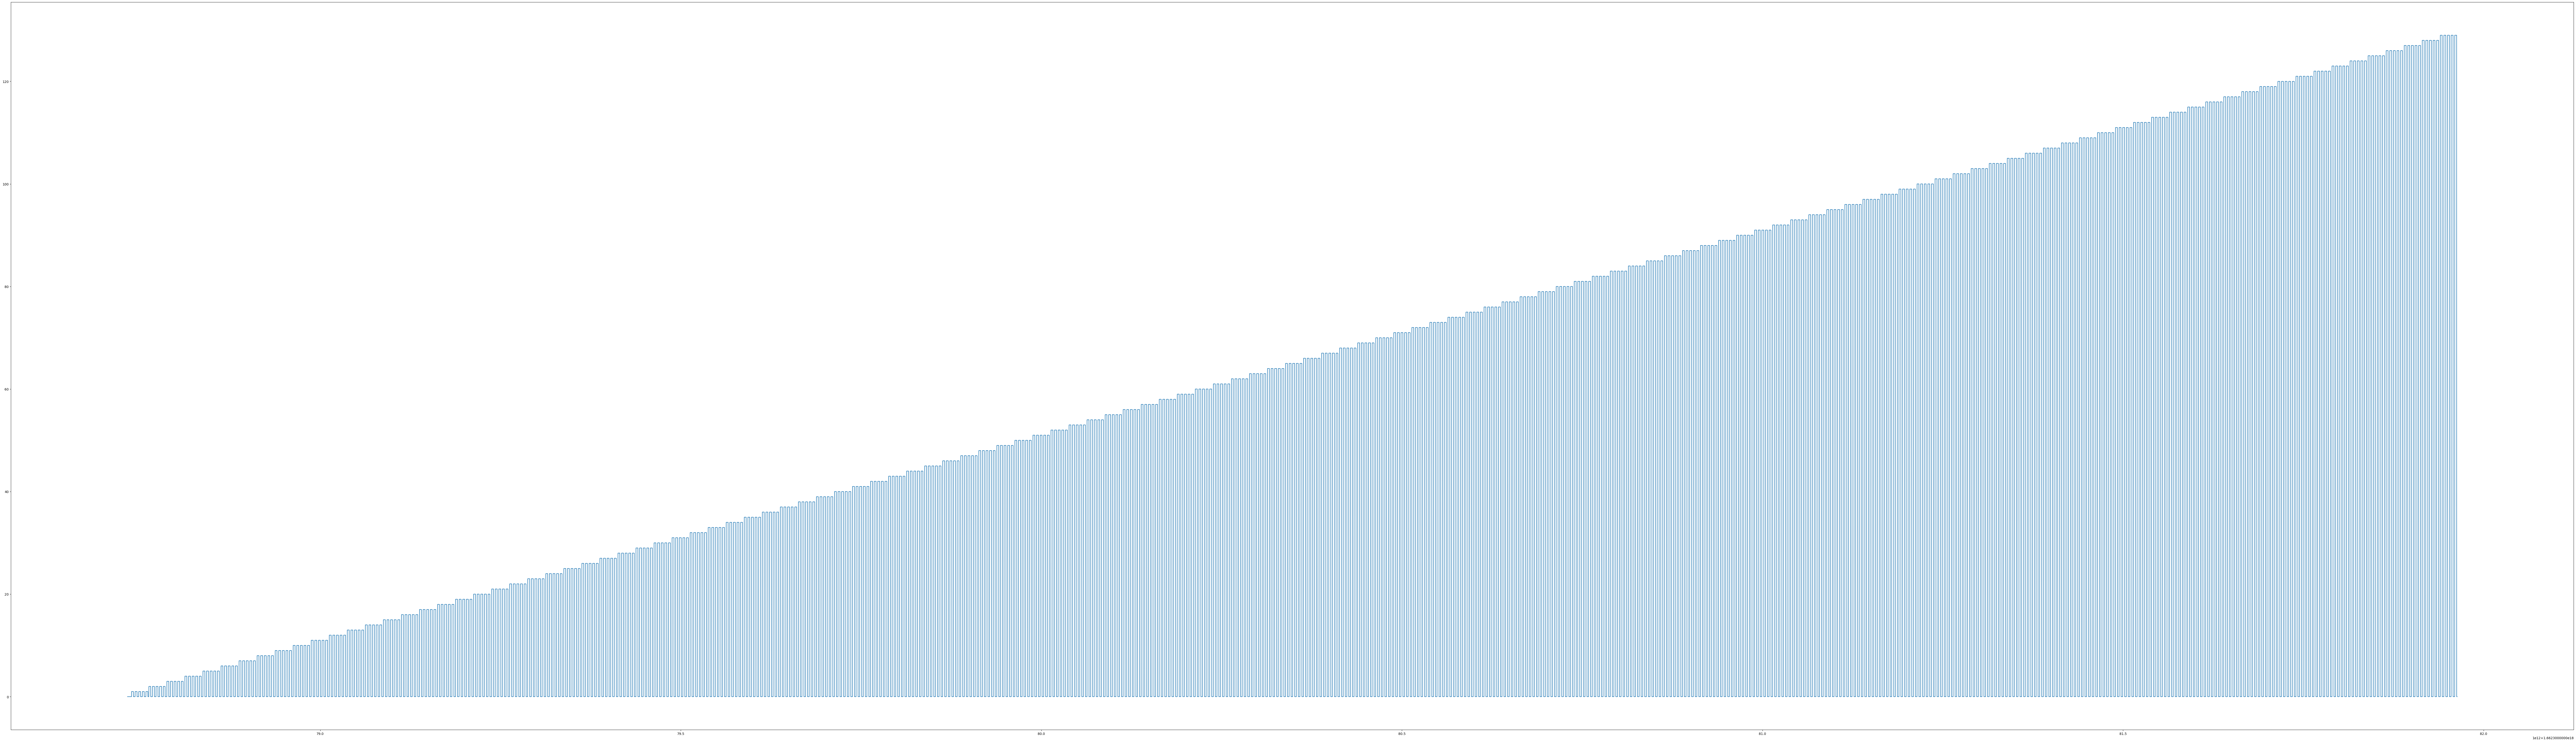

In [14]:
plt.figure(figsize=(140, 40))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int)

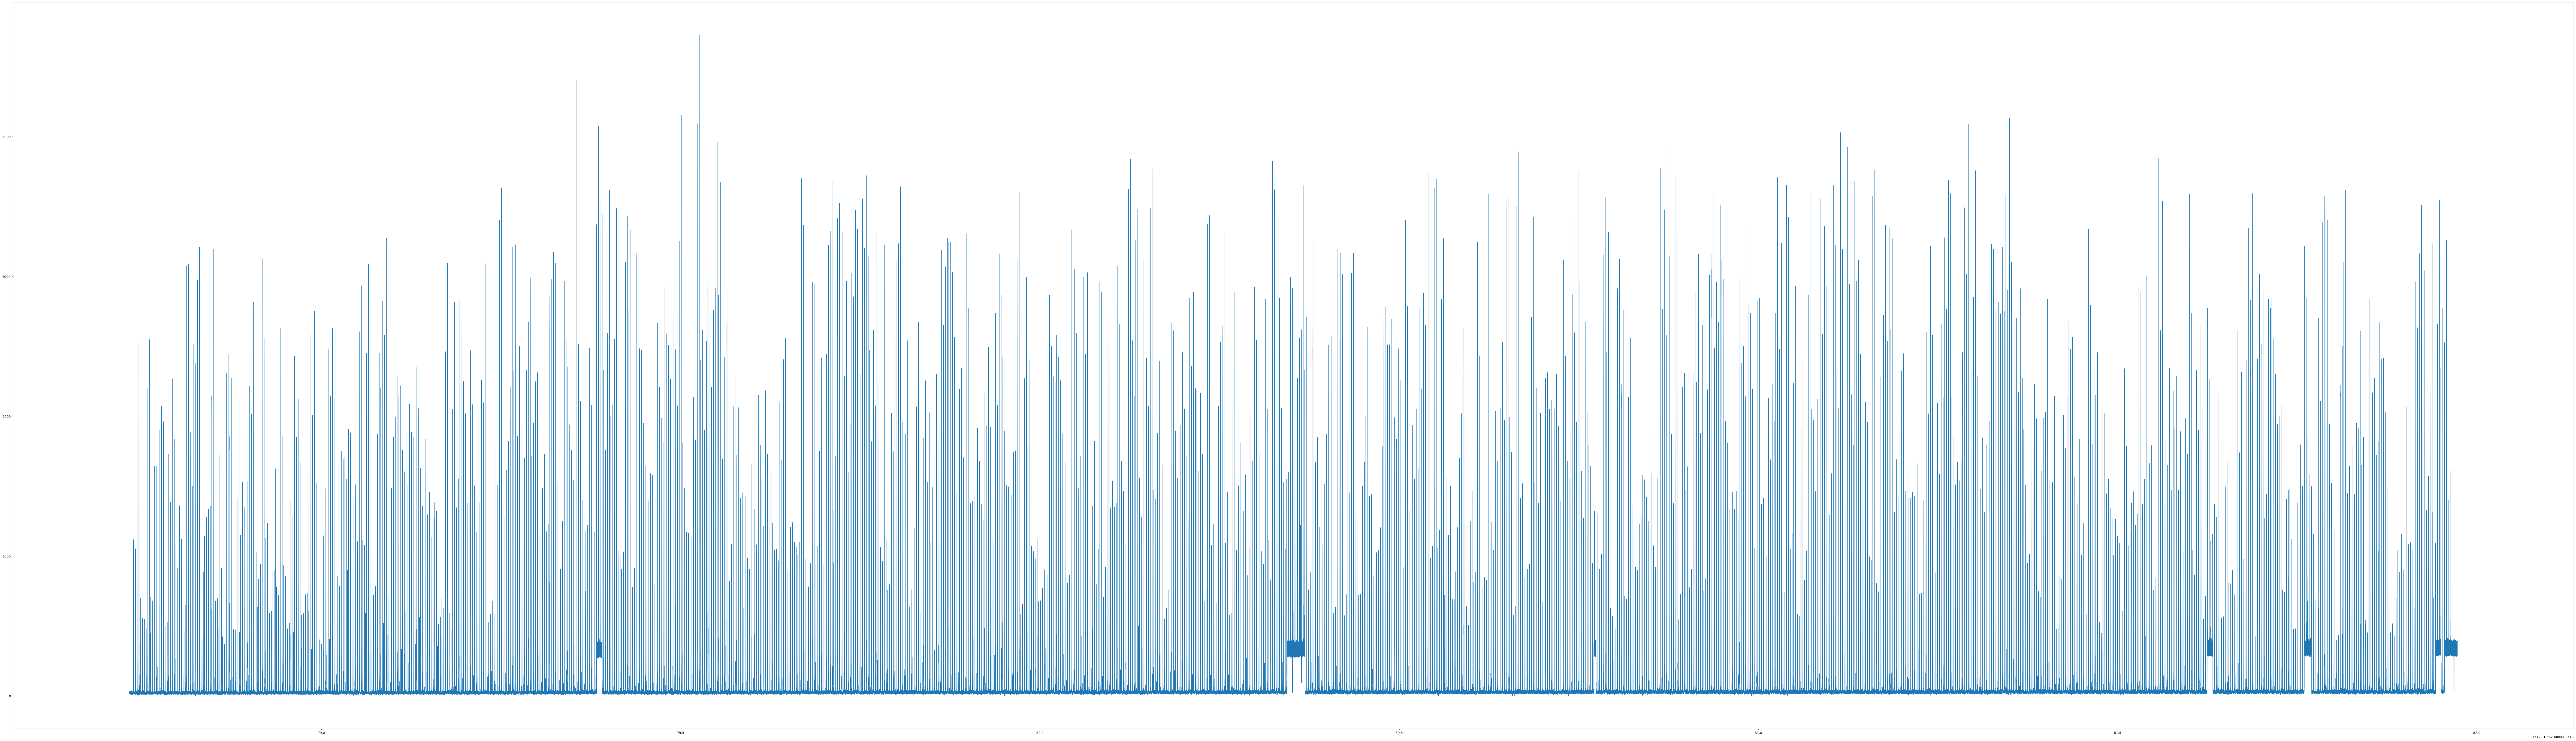

In [15]:
plt.figure(figsize=(140, 40))
plt.plot(event_packet_size_ts, event_packet_size)

In [117]:
f = interp1d(event_packet_size_ts, event_packet_size, kind='previous')
event_packet_int = f(contact_case_ts_alt_int)
event_packet_int.shape

(96927,)

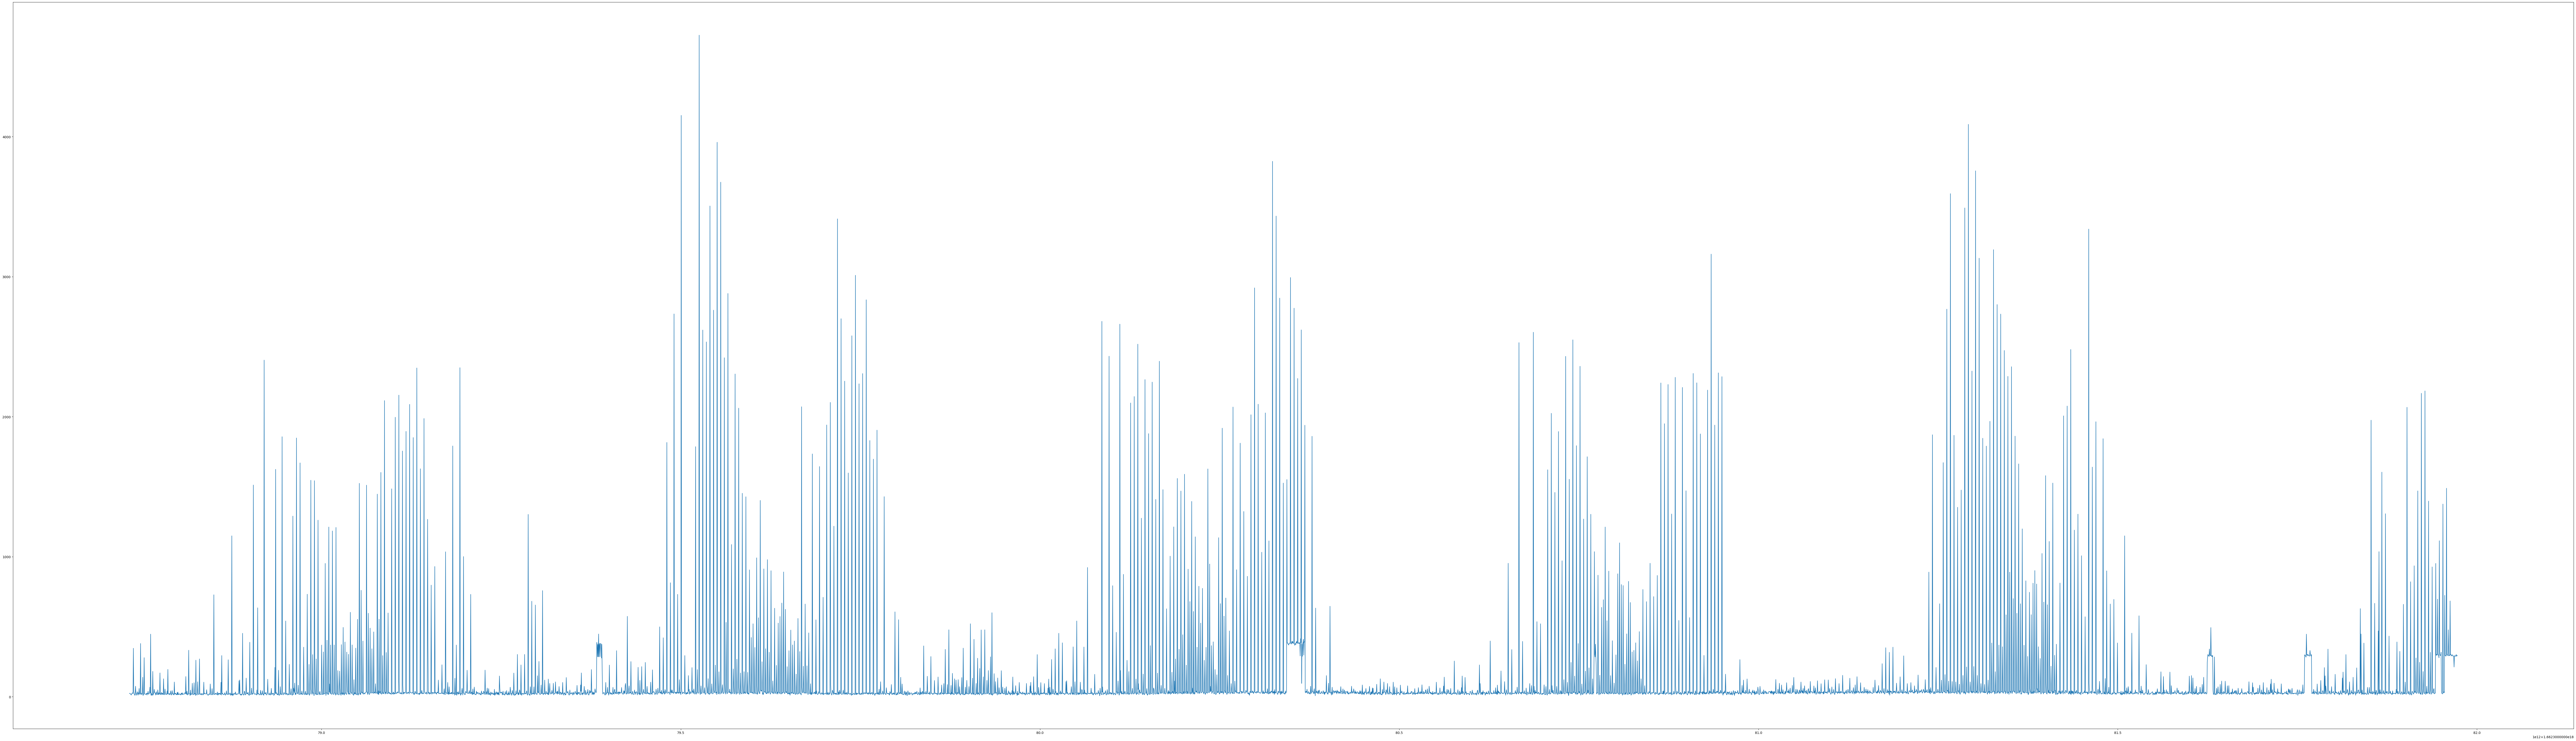

In [21]:
plt.figure(figsize=(140, 40))
#median_packet = medfilt(event_packet_size, kernel_size=21)
plt.plot(event_packet_int_size_ts, event_packet_int)

In [184]:
hist, bin_edges = np.histogram(ts, bins=int(1e5))

In [185]:
hist.shape

(100000,)

In [183]:
324021974.1e-9

0.3240219741

In [181]:
(ts[-1] - ts[0])*1e-4

324021974.1

In [110]:
3240219.741*1e-9

0.003240219741

subplot_size = 10
fig, axes = plt.subplots(8, 16, figsize=(16*subplot_size, 8*subplot_size))
from scipy.signal import find_peaks

for i, ax in enumerate(axes.ravel()):
    plt.sca(ax)
    case_i_idx = np.where(contact_case_alt_int == i + 1)[0]
    min_idx, max_idx = case_i_idx.min(), case_i_idx.max()
    cases_i_ts = contact_case_ts_alt_int[min_idx:max_idx+1]
    cases_i = contact_case_alt_int[min_idx:max_idx+1]
    cases_i = cases_i / cases_i.max()
    
    event_packet_i_ts = cases_i_ts
    event_packet_i = event_packet_int[min_idx:max_idx+1]
    event_packet_i = event_packet_i / event_packet_i.max()
    
    plt.plot(
        cases_i_ts, 
        cases_i
    )
    
    plt.plot(
        event_packet_i_ts,
        event_packet_i
    )
    
    peaks, _ = find_peaks(event_packet_i, distance=50)
    
    
    plt.scatter(
        event_packet_i_ts[peaks],
        event_packet_i[peaks],
        c='r',
        marker='x'
    )
    plt.title('case: ' + str(i+1))
    
plt.savefig('cases.pdf')

In [111]:
from scipy.signal import find_peaks
peaks_fixed_window, _ = find_peaks(hist, distance=70)


In [118]:
peaks_int, _ = find_peaks(event_packet_int, distance=50)
peaks_int.shape, 129*5*2

((1293,), 1290)

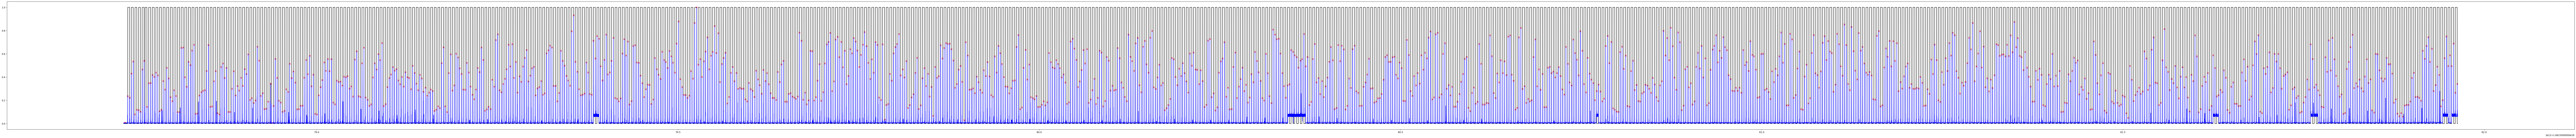

In [119]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int > 0, color='black')
plt.plot(contact_case_ts_alt_int, event_packet_int / event_packet_int.max(), color='blue')
plt.scatter(contact_case_ts_alt_int[peaks_int], event_packet_int[peaks_int] / event_packet_int.max(), c='r',marker='x')

In [198]:
peaks_fixed_window, _ = find_peaks(hist, distance=70)
peaks_fixed_window.shape

(1292,)

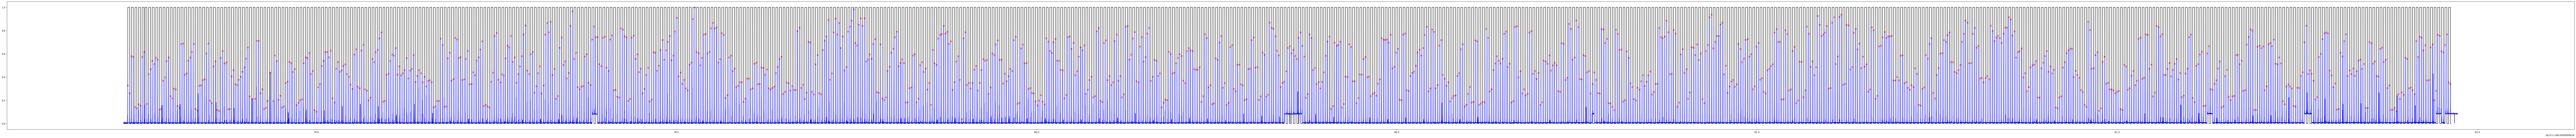

In [199]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int > 0, color='black')
plt.plot(bin_edges[:-1], (hist - hist.min()) / (hist.max() - hist.min()), c='blue')
plt.scatter(bin_edges[:-1][peaks_fixed_window], hist[peaks_fixed_window] / hist.max(), c='r',marker='x')

In [120]:
spurious_peaks = peaks_int[np.where(event_packet_int[peaks_int] < 50)[0]]
spurious_peaks

array([  36,   90,  903, 6048, 6169])

In [121]:
final_peaks = peaks_int[np.where(np.logical_not(np.isin(peaks_int, spurious_peaks)))[0]]
final_peaks

array([  171,   249,   319, ..., 96752, 96822, 96902])

subplot_size = 10
fig, axes = plt.subplots(8, 16, figsize=(16*subplot_size, 8*subplot_size))
from scipy.signal import find_peaks

for i, ax in enumerate(axes.ravel()):
    plt.sca(ax)
    case_i_idx = np.where(contact_case_alt_int == i + 1)[0]
    min_idx, max_idx = case_i_idx.min(), case_i_idx.max()
    cases_i_ts = contact_case_ts_alt_int[min_idx:max_idx+1]
    cases_i = contact_case_alt_int[min_idx:max_idx+1]
    cases_i = cases_i / cases_i.max()
    
    event_packet_i_ts = cases_i_ts
    event_packet_i = event_packet_int[min_idx:max_idx+1]
    event_packet_i = event_packet_i / event_packet_i.max()
    
    plt.plot(
        cases_i_ts, 
        cases_i
    )
    
    plt.plot(
        event_packet_i_ts,
        event_packet_i
    )
    
    peaks, _ = find_peaks(event_packet_i, distance=50)
    
    
    plt.scatter(
        event_packet_i_ts[peaks],
        event_packet_i[peaks],
        c='r',
        marker='x'
    )
    plt.title('case: ' + str(i+1))
    
plt.savefig('cases_fiter.pdf')

In [200]:
case_int_idx_flat = np.ravel(cases_int_idx)
peak_closest_case_idx = []
for peak in peaks_fixed_window:
    dists = np.abs(case_int_idx_flat - peak)
    closest_case_idx = case_int_idx_flat[np.argmin(dists)]
    peak_closest_case_idx.append(closest_case_idx)

In [210]:
645*2

1290

In [211]:
case_int_idx_flat = np.ravel(cases_int_idx)
peak_closest_case_idx = []
for peak in final_peaks:
    dists = np.abs(case_int_idx_flat - peak)
    closest_case_idx = case_int_idx_flat[np.argmin(dists)]
    peak_closest_case_idx.append(closest_case_idx)

In [201]:
len(peak_closest_case_idx)

1292

In [ ]:
1291

In [ ]:
cases_int_idx

In [207]:
spur = np.where(np.abs(peaks_fixed_window - peak_closest_case_idx) > 500)

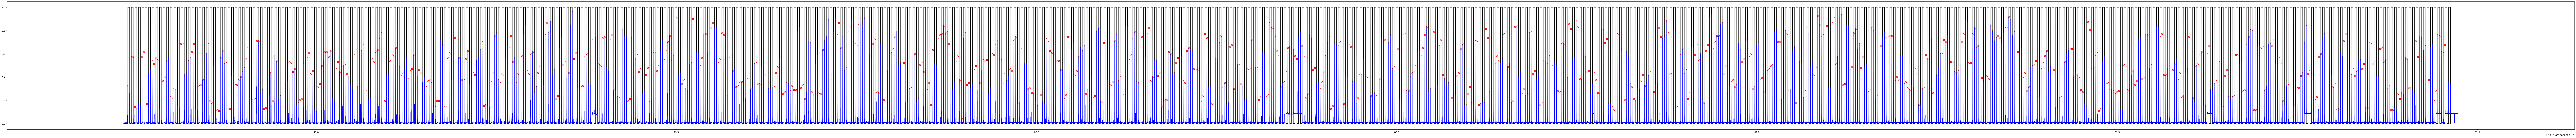

In [209]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int > 0, color='black')
plt.plot(bin_edges[:-1], (hist - hist.min()) / (hist.max() - hist.min()), c='blue')
plt.scatter(bin_edges[:-1][peaks_fixed_window], hist[peaks_fixed_window] / hist.max(), c='r',marker='x')
plt.scatter(bin_edges[:-1][spur], hist[spur] / hist.max(), c='r')


In [205]:
sum(np.abs(peaks_fixed_window - peak_closest_case_idx) > 500)

33

<AxesSubplot:>

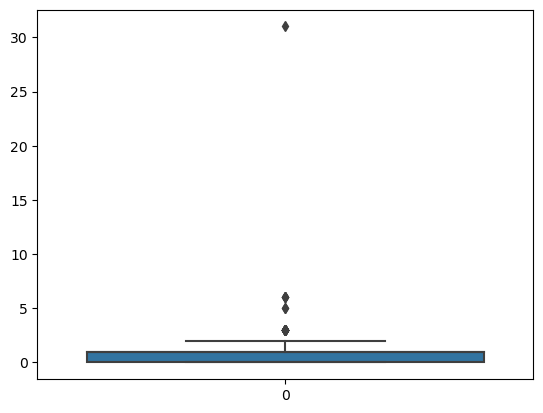

In [213]:
sns.boxplot(np.abs(final_peaks - peak_closest_case_idx))

In [ ]:
from scipy.stats import iqr,
iqr(final_peaks - peak_closest_case_idx, )